<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.2.6%20GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from statsmodels.base.model import GenericLikelihoodModel
from datetime import datetime
zero,one,two,five,ten,hundred=0e0,1e0,2e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns of the S&P 500 
SPX=download('^GSPC','1957-03-01').dropna()
SPX['Return']=SPX['Adj Close'].pct_change()*hundred
SPX.index=pd.DatetimeIndex(SPX.index).to_period('D')
SPX.dropna(inplace=True)
SPX.loc[SPX["Volume"]==0,"Volume"]=np.nan
SPX

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1957-03-04,44.060001,44.060001,44.060001,44.060001,44.060001,1.890000e+06,0.731595
1957-03-05,44.220001,44.220001,44.220001,44.220001,44.220001,1.860000e+06,0.363141
1957-03-06,44.230000,44.230000,44.230000,44.230000,44.230000,1.840000e+06,0.022610
1957-03-07,44.209999,44.209999,44.209999,44.209999,44.209999,1.830000e+06,-0.045219
1957-03-08,44.070000,44.070000,44.070000,44.070000,44.070000,1.630000e+06,-0.316669
...,...,...,...,...,...,...,...
2022-03-21,4462.399902,4481.750000,4424.299805,4461.180176,4461.180176,3.961050e+09,-0.043466
2022-03-22,4469.100098,4522.000000,4469.100098,4511.609863,4511.609863,3.962880e+09,1.130411
2022-03-23,4493.100098,4501.069824,4455.810059,4456.240234,4456.240234,4.014360e+09,-1.227270


Installing ARCH and fitting model with Normal innovations.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19933.507286985987
            Iterations: 12
            Function evaluations: 90
            Gradient evaluations: 12
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -19933.5
Distribution:                  Normal   AIC:                           39875.0
Method:            Maximum Likelihood   BIC:                           39905.8
                                        No. Observations:                16380
Date:                Sun, Mar 27 2022   Df Residuals:                    16379
Time:                        14:59:18   Df Model:                            1
                   

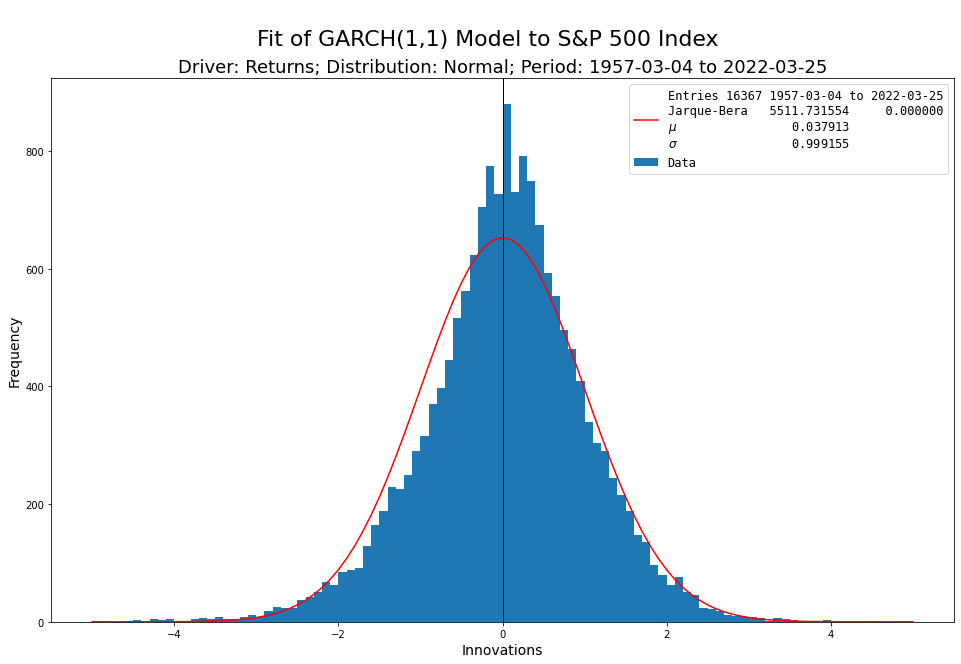

In [52]:
# fit a GARCH model using arch package
print("Installing ARCH and fitting model with Normal innovations.")
from arch.univariate import ConstantMean, GARCH, Normal

model = ConstantMean(SPX["Return"])
model.volatility = GARCH(1, 0, 1)
model.distribution = Normal()
fit=model.fit(update_freq=0)
print(fit.summary())
SPX["Volatility"]=fit.conditional_volatility
SPX["Innovations"]=SPX["Return"]/SPX["Volatility"]

# fit normal pdf to plot
from scipy.stats import norm as density,jarque_bera
params=density.fit(SPX["Innovations"])
print("Fitted Normal distribution: %g,%g" % params)
test=jarque_bera(SPX["Innovations"])
print("Jarque-Bera Test results: %g,%g" % test)

# Figure 2.8
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
counts,bins,patches=plot.hist(SPX["Innovations"],bins=np.linspace(-five,five,101),label='Data')
plot.plot(bins,density.pdf(bins)*(max(bins)-min(bins))/(len(bins)-1)*sum(counts),'-r',label="""Entries %d %s to %s
Jarque-Bera  %12.6f %12.6f
$\\mu$            %12.6f 
$\\sigma$            %12.6f""" % (
    sum(counts),min(SPX.index),max(SPX.index),
    test[0],test[1],
    params[0],
    params[1]
))
plot.axvline(color='black',lw=1)
plot.set_xlabel("Innovations",fontsize=14)
plot.set_ylabel("Frequency",fontsize=14)
figure.suptitle("\nFit of GARCH(1,1) Model to S&P 500 Index",fontsize=22)
plot.set_title("Driver: Returns; Distribution: Normal; Period: %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
pl.setp(plot.legend(loc='best',fontsize=12).texts,family='monospace');